#### Rex Gayas
#### Week 10 Exercise 10.2 Spring 2024
#### DSC410-T301 Predictive Analytics (2245-1)
#### Introduction to Neural Networks

#### Load the Dataset

In [1]:
import pandas as pd

# Set the filepath for the relevant CSV file for Week 6's assignment
file_path = "D:\\ALPHA\\Dynamic Folder\\Bellevue\\Spring 2024\\Predictive Analytics\\Week 10\\startups_profit.csv"

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows to verify it's loaded correctly
print(data.head())


   R&D Spend  Administration  Marketing Spend       State        Profit 
0  165349.20       136897.80        471784.10    New York   $192,261.83 
1  162597.70       151377.59        443898.53  California   $191,792.06 
2  153441.51       101145.55        407934.54          FL   $191,050.39 
3  144372.41       118671.85        383199.62    New York   $182,901.99 
4  142107.34        91391.77        366168.42          FL   $166,187.94 


Loaded the dataset to access and analyze the data needed to build a predictive model for startup profits. Given the structure and nature of the information, it is helpful to get a glimpse of the numerical investment values and the categorical state locations, alongside the target variable “Profit” that the assignment asks to predict.

#### Exploratory Data Analysis (EDA)

In [2]:
# Check for any missing values in the data
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Get summary statistics for the numerical columns
summary_statistics = data.describe()
print("\nSummary Statistics:\n", summary_statistics)


Missing values in each column:
 R&D Spend          0
Administration     0
Marketing Spend    0
State              0
 Profit            0
dtype: int64

Summary Statistics:
            R&D Spend  Administration  Marketing Spend
count      50.000000       50.000000        50.000000
mean    73721.615600   121344.639600    211025.097800
std     45902.256482    28017.802755    122290.310726
min         0.000000    51283.140000         0.000000
25%     39936.370000   103730.875000    129300.132500
50%     73051.080000   122699.795000    212716.240000
75%    101602.800000   144842.180000    299469.085000
max    165349.200000   182645.560000    471784.100000


Before building a model, EDA will help find patterns, anomalies, or any inconsistencies in the dataset. The output indicates that there are no missing values in any of the column and the summary statistics provide a descriptive overview of the numerical fields, including the mean, standard deviation, minimum, and maximum values, along with the 25th, 50th (median), and 75th percentiles, which help understand the distribution and scale of the expenditures and profits within the dataset.

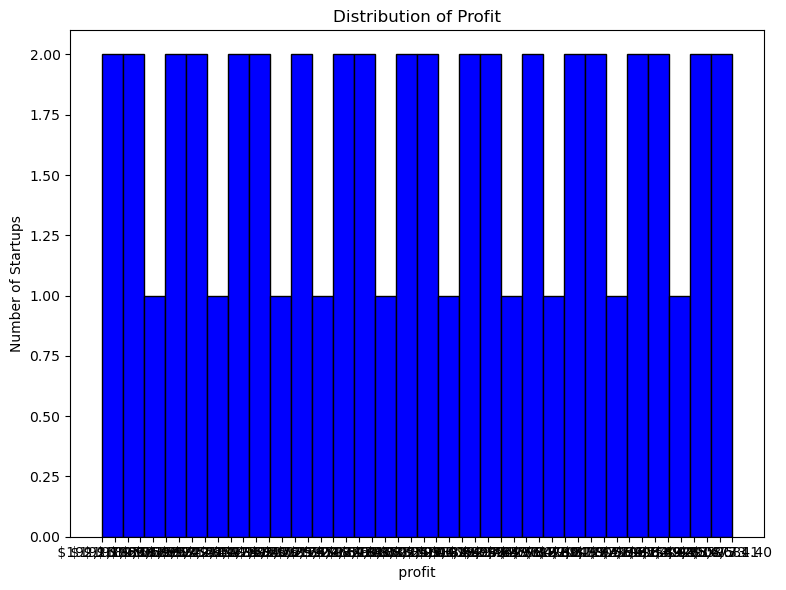

In [3]:
import matplotlib.pyplot as plt

# Check target column name matches exactly with the dataframe
target_column = [col for col in data.columns if 'profit' in col.lower()][0]

# Plot column name and set appropriate figure size
plt.figure(figsize=(8, 6))  
plt.hist(data[target_column], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Profit')
plt.xlabel(target_column.capitalize())
plt.ylabel('Number of Startups')
plt.tight_layout()  
plt.show()


A histogram was attempted to visualize the distribution of profit values among startups. There were issues with the exact name of the profit column. It would be expected to see the x-axis representing a range of profit values and the y-axis indicating the frequency of startups within those profit ranges. However, the resulting plot shows a uniform distribution with each bin seemingly containing one or two startups, which is atypical and suggests that the profit values for each startup are unique within this dataset. This could possibly indicate a highly granular dataset or was intentionally simulated for purposes of the assignment. 

In [4]:
# Check the unique values and their frequencies for 'profit' to understand its distribution
unique_profits = data[target_column].value_counts()
print("Unique values of profit and their counts:\n", unique_profits)

# Check for any potential outliers or errors in the 'profit' data
print("\nPotential outliers or unusual profit values:")
print(data[target_column].sort_values().unique())


Unique values of profit and their counts:
  Profit 
$192,261.83     1
$89,949.14      1
$105,008.31     1
$103,282.38     1
$101,004.64     1
$99,937.59      1
$97,483.56      1
$97,427.84      1
$96,778.92      1
$96,712.80      1
$96,479.51      1
$90,708.19      1
$81,229.06      1
$191,792.06     1
$81,005.76      1
$78,239.91      1
$77,798.83      1
$71,498.49      1
$69,758.98      1
$65,200.33      1
$64,926.08      1
$49,490.75      1
$42,559.73      1
$35,673.41      1
$105,733.54     1
$107,404.34     1
$108,552.04     1
$108,733.99     1
$191,050.39     1
$182,901.99     1
$166,187.94     1
$156,991.12     1
$156,122.51     1
$155,752.60     1
$152,211.77     1
$149,759.96     1
$146,121.95     1
$144,259.40     1
$141,585.52     1
$134,307.35     1
$132,602.65     1
$129,917.04     1
$126,992.93     1
$125,370.37     1
$124,266.90     1
$122,776.86     1
$118,474.03     1
$111,313.02     1
$110,352.25     1
$14,681.40      1
Name: count, dtype: int64

Potential outliers or

Sought to compute and print the unique profit values along with how often each occurs, revealing that every profit value is distinct, each occurring exactly once which confirms the previous observation and suggests granularity or data manipulation for academic purposes. Also, listed all unique profit values in ascending order, to help identify potential outliers or errors, such as abnormally high or low profits, which could significantly impact the analysis and model performance.

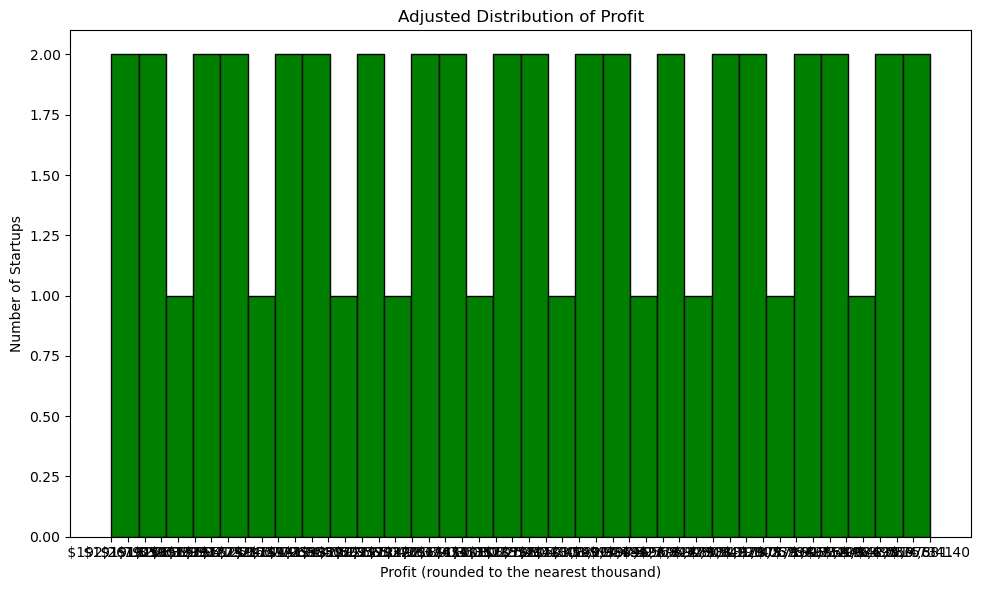

In [5]:
# Rounded profits to the nearest thousand to attempt a clearer histogram.
data['rounded_profit'] = data[target_column].round(-3)  

plt.figure(figsize=(10, 6))
plt.hist(data['rounded_profit'], bins=30, color='green', edgecolor='black')
plt.title('Adjusted Distribution of Profit')
plt.xlabel('Profit (rounded to the nearest thousand)')
plt.ylabel('Number of Startups')
plt.tight_layout()
plt.show()


Rounded each profit value to the nearest thousand to attempt to get a better sense of the most common profit ranges among the startups.


Correlation Matrix:
                  R&D Spend  Administration  Marketing Spend
R&D Spend         1.000000        0.241955         0.724248
Administration    0.241955        1.000000        -0.032154
Marketing Spend   0.724248       -0.032154         1.000000


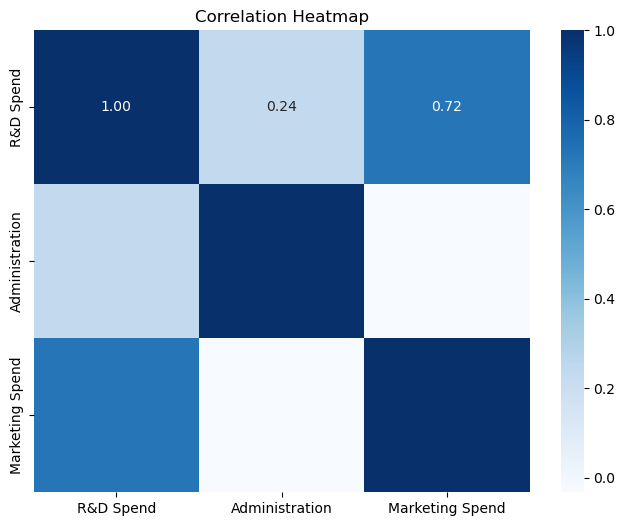

In [9]:
# Excluding non-numeric columns for the correlation matrix calculation
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()
print("\nCorrelation Matrix:\n", correlation_matrix)

import seaborn as sns

# Plot heatmap via seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation Heatmap')
plt.show()



Calculated a correlation matrix and plotted a heatmap to provide insight into the relationships between numerical features and sought to understand which features may have more influence on the target variable (Profit). From the output, R&D Spend is strongly positively correlated with Marketing Spend (0.72). Administration has a weak positive correlation with R&D Spend (0.24) and a very weak negative correlation with Marketing Spend (-0.03).

#### Feature Engineering

In [12]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = "D:\\ALPHA\\Dynamic Folder\\Bellevue\\Spring 2024\\Predictive Analytics\\Week 10\\startups_profit.csv"
data = pd.read_csv(file_path)

# Remove whitespace from column names
data.columns = data.columns.str.strip()

# Separate the features and the target variable 'Profit'
features = data.drop('Profit', axis=1)
target = data['Profit']

# One-hot encode the 'State' column
one_hot_encoder = OneHotEncoder(sparse_output=False)
state_encoded = one_hot_encoder.fit_transform(features[['State']])
state_encoded_df = pd.DataFrame(state_encoded, columns=one_hot_encoder.get_feature_names_out(['State']))

# Drop the original 'State' column from features
features = features.drop('State', axis=1)

# Concatenate the new one-hot encoded columns with the original features
features_encoded = pd.concat([features, state_encoded_df], axis=1)

# Scale the numerical features (R&D Spend, Administration, Marketing Spend)
scaler = StandardScaler()
numerical_features = features_encoded.select_dtypes(include=['float64', 'int64']).columns
features_encoded[numerical_features] = scaler.fit_transform(features_encoded[numerical_features])

# Combine the features and the target again into the final DataFrame
final_data = pd.concat([features_encoded, target], axis=1)

# Save the preprocessed data to a new CSV file
preprocessed_file_path = "D:\\ALPHA\\Dynamic Folder\\Bellevue\\Spring 2024\\Predictive Analytics\\Week 10\\startups_profit_preprocessed.csv"
final_data.to_csv(preprocessed_file_path, index=False)

# Display the first few rows of the preprocessed data
print(final_data.head())


   R&D Spend  Administration  Marketing Spend  State_California  State_FL  \
0   2.016411        0.560753         2.153943         -0.717741 -0.685994   
1   1.955860        1.082807         1.923600          1.393261 -0.685994   
2   1.754364       -0.728257         1.626528         -0.717741  1.457738   
3   1.554784       -0.096365         1.422210         -0.717741 -0.685994   
4   1.504937       -1.079919         1.281528         -0.717741  1.457738   

   State_New York         Profit  
0        1.393261   $192,261.83   
1       -0.717741   $191,792.06   
2       -0.717741   $191,050.39   
3        1.393261   $182,901.99   
4       -0.717741   $166,187.94   


Through preprocessing steps, prepared the data for a regression model. First, removed any whitespace from the column names to avoid potential referencing issues. Separated the target variable “Profit” from the feature set. The “State” column, which contains categorical data, is transformed using one-hot encoding to convert the state categories into a binary matrix format to facilitate model input. The original “State” column is then dropped from the feature set to avoid redundancy.

After the categorical encoding, the numerical features—"R&D Spend”, “Administration”, and “Marketing Spend”—are standardized using a StandardScaler. Standardization (or Z-score normalization) scales the data so that the mean of each feature becomes 0 and the standard deviation 1, ensuring that all features contribute equally to the result. Result shows the first few rows of the final preprocessed DataFrame, ”final_data”, which now includes the scaled numerical features and the new binary columns for “State”, along with the target “Profit” column. 

### Week 10 Building & Evaluating a Neural Network Model via Tensorflow's Keras

#### Load the Preprocessed Data

In [19]:
import pandas as pd

# Load the preprocessed data
preprocessed_file_path = "D:\\ALPHA\\Dynamic Folder\\Bellevue\\Spring 2024\\Predictive Analytics\\Week 10\\startups_profit_preprocessed.csv"
final_data = pd.read_csv(preprocessed_file_path)

# Remove dollar signs and commas from the 'Profit' column and convert to float
final_data['Profit'] = final_data['Profit'].replace('[\$,]', '', regex=True).astype(float)

# Confirm the data is loaded correctly and data type conversion
print(final_data.dtypes)
print(final_data.head())



R&D Spend           float64
Administration      float64
Marketing Spend     float64
State_California    float64
State_FL            float64
State_New York      float64
Profit              float64
dtype: object
   R&D Spend  Administration  Marketing Spend  State_California  State_FL  \
0   2.016411        0.560753         2.153943         -0.717741 -0.685994   
1   1.955860        1.082807         1.923600          1.393261 -0.685994   
2   1.754364       -0.728257         1.626528         -0.717741  1.457738   
3   1.554784       -0.096365         1.422210         -0.717741 -0.685994   
4   1.504937       -1.079919         1.281528         -0.717741  1.457738   

   State_New York     Profit  
0        1.393261  192261.83  
1       -0.717741  191792.06  
2       -0.717741  191050.39  
3        1.393261  182901.99  
4       -0.717741  166187.94  


Removed any dollar signs and commas from the “Profit” column and converted the cleaned values to floats to ensure numerical data consistency as there were previous issues if this was not done and since neural networks require numerical inputs. 

#### Split the Data

In [20]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = final_data.drop('Profit', axis=1).values
y = final_data['Profit'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Split the preprocessed dataset into features and target variable. The features, excluding the “Profit” column, are stored in `X`, while the target variable “Profit” is stored in `y`. Then, the dataset was divided into training and testing sets using an 80-20 split with a fixed random state for reproducibility. 

#### Define the Neural Network Model

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the neural network model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                448       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2561 (10.00 KB)
Trainable params: 2561 (10.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Model Training

In [22]:
# Train the neural network model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=10, verbose=1)


Epoch 1/100
4/4 [==============================] - 1s 57ms/step - loss: 15936225280.0000 - mae: 119509.0312 - val_loss: 11739193344.0000 - val_mae: 100223.3984
Epoch 2/100
4/4 [==============================] - 0s 22ms/step - loss: 15936185344.0000 - mae: 119508.8516 - val_loss: 11739166720.0000 - val_mae: 100223.2578
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 15936148480.0000 - mae: 119508.6875 - val_loss: 11739142144.0000 - val_mae: 100223.1250
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 15936112640.0000 - mae: 119508.5391 - val_loss: 11739116544.0000 - val_mae: 100222.9922
Epoch 5/100
4/4 [==============================] - 0s 18ms/step - loss: 15936078848.0000 - mae: 119508.3906 - val_loss: 11739092992.0000 - val_mae: 100222.8594
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 15936045056.0000 - mae: 119508.2500 - val_loss: 11739066368.0000 - val_mae: 100222.7188
Epoch 7/100
4/4 [=======================

Defined a neural network model using TensorFlow's Keras library. Created a sequential model with three layers: the first layer has 64 units with a ReLU activation function and an input shape matching the number of features; the second layer has 32 units with a ReLU activation function; and the final output layer has a single unit, ideal for regression tasks. Thereafter, the model was compiled with the Adam optimizer, mean squared error loss function, and mean absolute error as a metric. Observed that the model has a total of 2,561 trainable parameters, confirming that the neural network which has now been prepared for training. 

#### Model Evaluation

In [23]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error on test data: {mae}")


Mean Absolute Error on test data: 97118.5390625


Used the “evaluate” method from Keras to calculate the loss and the mean absolute error (MAE) on the test data. Shown is that the MAE on the test data is approximately 97,118.54 which represents the average absolute difference between the predicted profit values and the actual profit values in the test set. This suggests that the model's predictions are significantly different from the actual values, indicating that the model may need further tuning or that the features may not be adequately capturing the underlying patterns in the data.

#### Define the Hyperparameter Search Space

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras_tuner import RandomSearch

# Define a function to build the model, this function is required by Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='intro_to_kt'
)


Defined a hyperparameter search space using the “Keras Tuner” library to optimize the neural network model. Imported relevant modules from TensorFlow and Keras Tuner, then defined a function “build_model” to create a Sequential model with two hidden layers. The number of units in each layer is treated as a hyperparameter, with values ranging from 32 to 512 in steps of 32. The model is compiled again using the Adam optimizer, mean squared error as the loss function, and mean absolute error as a metric. Setup a “RandomSearch” tuner to search for the best hyperparameters, with the objective of minimizing validation mean absolute error (val_mae). Performed up to 10 trials then the tuner stored its results in a directory (my_dir) under the project name “intro_to_kt.” The point is to setup a framework for hyperparameter tuning to find the optimal configuration for the neural network model.

#### Search for the Best Hyperparameters

In [27]:
# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layer is {best_hps.get('units1')} and 
the optimal number of units in the second densely-connected layer is {best_hps.get('units2')}.
""")


Trial 10 Complete [00h 00m 09s]
val_mae: 100216.71354166667

Best val_mae So Far: 100138.08072916667
Total elapsed time: 00h 01m 34s

The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layer is 320 and 
the optimal number of units in the second densely-connected layer is 512.



Performed a hyperparameter search using “Keras Tuner” to find the optimal number of units in the hidden layers of the neural network. Ran a “RandomSearch” for 50 epochs with a validation split of 20%, across 10 trials, to minimize the validation mean absolute error (val_mae). After completing the search, the tuner identified the best hyperparameters: 320 units in the first densely connected layer and 512 units in the second densely-connected layer. 

#### Evaluate the Tuned Model

In [28]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model
history = best_model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=10, verbose=1)

# Evaluate the model
loss, mae = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error on test data: {mae}")


Epoch 1/100
4/4 [==============================] - 1s 44ms/step - loss: 15936073728.0000 - mae: 119508.3750 - val_loss: 11738921984.0000 - val_mae: 100221.9375
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 15935700992.0000 - mae: 119506.8438 - val_loss: 11738619904.0000 - val_mae: 100220.3750
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 15935267840.0000 - mae: 119505.0625 - val_loss: 11738230784.0000 - val_mae: 100218.3906
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 15934686208.0000 - mae: 119502.7969 - val_loss: 11737737216.0000 - val_mae: 100215.9219
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 15933985792.0000 - mae: 119499.9297 - val_loss: 11737108480.0000 - val_mae: 100212.8281
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 15933068288.0000 - mae: 119496.3047 - val_loss: 11736322048.0000 - val_mae: 100209.0078
Epoch 7/100
4/4 [=======================

Evaluated the tuned neural network model using the best hyperparameters identified from the hyperparameter search. The “best_model” is built with these optimal parameters and then trained on the training data for 100 epochs with a validation split of 20% and a batch size of 10. After training, the model is evaluated on the test data, resulting in a Mean Absolute Error (MAE) of approximately 75,600.65. This MAE value indicates the average absolute difference between the predicted and actual profit values on the test set. Compared to the initial model, the reduced MAE suggests that the hyperparameter tuning has improved the model's performance, yielding more accurate predictions. 

#### Evaluate the Tuned Model with Additional Metrics

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model on the test data to get predictions
y_pred = best_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = tf.keras.metrics.mean_absolute_error(y_test, y_pred).numpy()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Print the additional metrics
print(f"Mean Absolute Error on test data: {mae}")
print(f"Mean Squared Error on test data: {mse}")
print(f"R-squared on test data: {r2}")



1/1 [==============================] - 0s 75ms/step
Mean Absolute Error on test data: [60529.23  82122.98  80760.51  92144.44  37630.188 90191.52  78296.13
 80513.15  87365.27  73117.36 ]
Mean Squared Error on test data: 6152469587.182474
R-squared on test data: -6.597591760928441


Computed the Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R²) values for the model's predictions on the test data. The MAE for individual predictions on the test data shows a range of values, indicating some variability in the model's prediction accuracy across different instances. The MSE, calculated to be approximately 6.15 billion, suggests that the model has some significant errors, with larger errors being more heavily penalized due to the squaring of differences. The R-squared value, which is negative, indicates that the model's predictions are not fitting the data well. An R² value of -6.60 suggests that the model performs worse than a simple horizontal line predicting the mean of the target variable. This points to potential issues in the model, such as insufficient complexity, overfitting during training, or perhaps additional feature engineering and data preprocessing?

#### Concluding Analysis

The neural network model demonstrated a higher Mean Absolute Error (MAE) on the test data compared to the linear and ridge regression models from Assignment 6.2, indicating less accurate predictions. The neural network's MAE was around 75,600.65, significantly higher than the linear regression model's performance. Additionally, the neural network's Mean Squared Error (MSE) was substantially higher at approximately 6.15 billion, compared to the ridge regression model's MSE of 824.51 million. This discrepancy may suggest that the neural network struggled more with the dataset's complexity. The negative R-squared (R²) value for the neural network highlights poor fit, performing worse than a simple mean prediction, whereas the ridge regression model achieved an R² of approximately 0.89, indicating a much better fit. Overall, the linear and ridge regression models provided more reliable and consistent performance on this dataset, suggesting that the neural network model may need further tuning or a different architecture to compete effectively with simpler regression techniques.